In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

import sklearn
import os
import duckdb
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda, ReLU

from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.regularizers import L2
from keras.metrics import Mean, MeanAbsoluteError
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

from sklearn.dummy import DummyRegressor

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

# Geospatial 
from geopy import distance
import geopandas as gpd

np.random.seed(1234)
tf.random.set_seed(1234)

2024-05-10 10:43:18.676720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 10:43:18.704341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 10:43:18.704380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 10:43:18.704407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 10:43:18.710316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 10:43:18.711000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
df_taxi = pd.read_parquet("data/processed/yellow_taxi_2023.parquet")

In [5]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))



class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """
    
    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = tfp.random.rademacher(tf.shape(x))
            r = tfp.random.rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = tfp.random.rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))


In [6]:
class BayesianDenseNetwork(tf.keras.Model):
    """A multilayer fully-connected Bayesian neural network
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network
    """
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([s.losses for s in self.steps])


In [14]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, with
    two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer
        in the core network.
    units : List[int]
        Number of output dimensions for each layer
        in the head networks.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create sub-networks
        self.core_net = BayesianDenseNetwork(units)
        self.loc_net = BayesianDenseNetwork([units[-1]]+head_units)
        self.std_net = BayesianDenseNetwork([units[-1]]+head_units)

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their 
            variational distributions (if True, the default), or
            just use the Maximum a Posteriori parameter value
            estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor of shape (Nsamples, 2)
            Output of this model, the predictions.  First column is
            the mean predictions, and second column is the standard
            deviation predictions.
        """
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Ensure consistent dtypes
        loc = tf.cast(preds[:, 0], dtype=tf.float32)
        scale = tf.cast(preds[:, 1], dtype=tf.float32)
        y = tf.cast(y[:, 0], dtype=tf.float32)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(loc, scale).log_prob(y)
        
        
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from predictive distributions"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return (self.core_net.losses +
                self.loc_net.losses +
                self.std_net.losses)


In [15]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

# Split the dataframe into dependent abd independent columns
Y_taxi = df_taxi['trip_duration'].copy()
X_taxi = df_taxi.drop('trip_duration', axis=1)

# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=X_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = X_taxi[tr_ind].values
y_train = Y_taxi[tr_ind].values
x_val = X_taxi[~tr_ind].values
y_val = Y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)


2024-05-10 11:10:11.449104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65562504 exceeds 10% of free system memory.


In [16]:

# Instantiate the model
model2 = BayesianDensityNetwork([7, 256, 128], [64, 32, 1])
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=L_RATE)

N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] += train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)


2024-05-10 11:10:13.964646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65562504 exceeds 10% of free system memory.
2024-05-10 11:10:35.896227: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 299719680 exceeds 10% of free system memory.


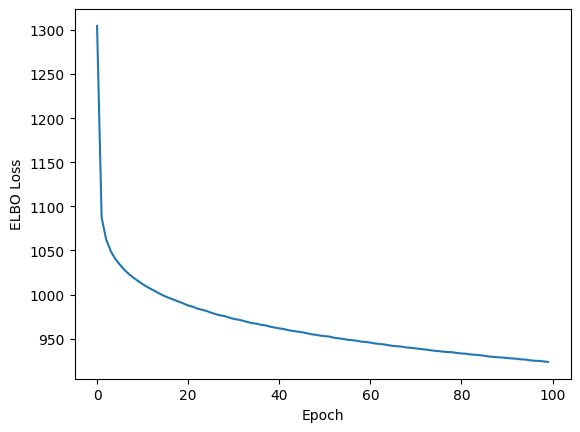

In [17]:
# Plot the ELBO Loss over training
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()


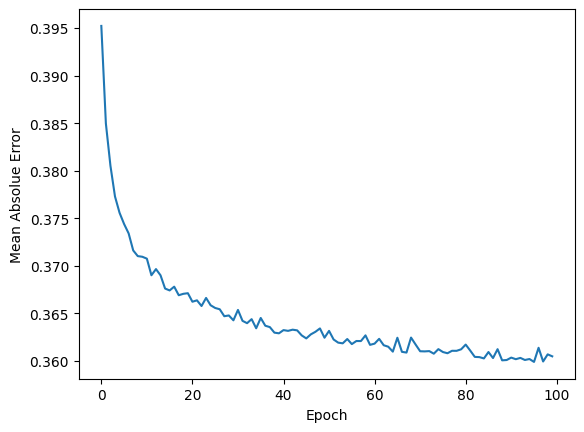

In [18]:
# Plot error over training
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()
